In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cleaning and Merging #
## Read all the data and extract the features from 2016 to 2021 into one dataset ##

In [2]:
# Use Residential Buldings as the template for the final dataset

# Clean the data - remove empty rows
df = pd.read_csv("Data/ResidentialBuildingPermits_Annualy.csv")
df = df.dropna(subset=['County/City'])
df = df[df['County/City'].str.strip() != ''] # Removes blank values

# Step 1: Melt the dataframe to long format (years as rows)
id_vars = ['County/City']
value_vars = [str(year) for year in range(2000, 2023)]
df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, 
                    var_name='Year', value_name='Annual_Permits')

# Clean the permits data
df_melted['Annual_Permits'] = df_melted['Annual_Permits'].astype(str).str.replace(',', '')
df_melted['Annual_Permits'] = pd.to_numeric(df_melted['Annual_Permits'], errors='coerce')
df_melted = df_melted.dropna(subset=['Annual_Permits'])
df_melted['Year'] = df_melted['Year'].astype(int)

# Step 2: Create monthly data by forward filling
monthly_data = []
for _, row in df_melted.iterrows():
    county_city = row['County/City']
    year = row['Year']
    annual_permits = row['Annual_Permits']
    monthly_permits = annual_permits / 12
    if pd.isna(annual_permits):
        # Skip or fill zeros
        continue  # or fill zeros for all months
    elif annual_permits == 0:
        # All months zero
        for month in range(1, 13):
            monthly_data.append({'county_city': county_city, 'year': year, 'month': month, 'permits': 0})
    elif annual_permits < 12:
        # Distribute 1 permit per month for the first few months
        for month in range(1, 13):
            permits = 1 if month <= annual_permits else 0
            monthly_data.append({'county_city': county_city, 'year': year, 'month': month, 'permits': permits})
    else:
        # Normal case
        monthly_permits_int = annual_permits // 12
        remainder = annual_permits % 12
        for month in range(1, 13):
            permits = monthly_permits_int + (1 if month <= remainder else 0)
            monthly_data.append({'county_city': county_city, 'year': year, 'month': month, 'permits': permits})

df_monthly = pd.DataFrame(monthly_data)

# Set scope from 2016 to 2021 and add Id
df_final = df_monthly[(df_monthly["year"] >= 2016) & (df_monthly["year"] <= 2021)].copy()
df_final.reset_index(drop=True, inplace=True)
df_final['id'] = df_final.index
df_final = df_final[['id', 'county_city', 'year', 'month', 'permits']]

In [3]:
# Adding home sales feature

df = pd.read_csv("Data/HomeSales_Monthly.csv")

df = df[df['County/City'] != "Franklin City"].copy()

# Converting to long format

id_vars = ['County/City']
value_vars = [col for col in df.columns if col != 'County/City']
df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, 
                    var_name='Year', value_name='home_sales')

df_melted['home_sales'] = df_melted['home_sales'].astype(str).str.replace(',', '')

# Adding the month and separating the year columns

df_melted["Year"] = df_melted["Year"].astype(str)
df_melted["Year"] = df_melted["Year"].str.replace(' ', '')
df_melted["Year"] = df_melted["Year"].str.split("-")
df_melted = df_melted.rename(columns={"Year": "year",
                                     "County/City": 'county_city'})

month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df_melted['month'] = df_melted['year'].apply(lambda x: month_map.get(x[1]))
df_melted['year'] = df_melted['year'].apply(lambda x: x[0])
df_melted['year'] = df_melted['year'].astype(int)
df_melted = df_melted[(df_melted['year'] >= 2016) & (df_melted['year'] <= 2021)]
df_melted = df_melted.sort_values(by=['county_city', 'year']).reset_index(drop=True)

df_final = df_final.merge(
    df_melted[['county_city', 'year', 'month', 'home_sales']],
    on=['county_city', 'year', 'month'],
    how='left'
)

In [4]:
# Adding population feature

df = pd.read_csv("Data/County-and-City-Population-2010-2023.csv")
df = df.dropna(subset=['county_city'])
df = df[df['county_city'].str.strip() != ''] # Removes blank values

id_vars = ['county_city']
value_vars = [col for col in df.columns if col != 'county_city']
df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, 
                    var_name='year', value_name='population')

df_melted['population'] = df_melted['population'].astype(str).str.replace(',', '')

# Adding a month column and forward filling all 12 months with the same population

monthly_data = []

for _, row in df_melted.iterrows():
    county = row['county_city'][1:].split(',')[0]
    year = row['year']
    population = row['population']

    for i in range(1, 13):
        monthly_data.append(
            {'county_city': county,
                    'year': year,
                    'month': i,
                    'population': population
            })

# Reduce the scope to 5 years and remove the unique counties/cities

df_monthly = pd.DataFrame(monthly_data)
df_monthly['year'] = df_monthly['year'].astype(int)
df_monthly = df_monthly[(df_monthly['year'] >= 2016) & (df_monthly['year'] <= 2021)]
df_monthly = df_monthly[df_monthly['county_city'] != "Franklin City"].copy()

df_final = df_final.merge(
    df_monthly[['county_city', 'year', 'month', 'population']],
    on=['county_city', 'year', 'month'],
    how='left'
)

In [5]:
# Adding Job Total Features
df = pd.read_csv("Data/Job_Totals.csv")
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(str)

df = df[(df['year'] >= 2016) & (df['year'] <= 2021)]
df['month'] = df['month'].apply(lambda x: month_map.get(x))

df_final = df_final.merge(
    df[['year', 'month', 'Jobs (000s, nonfarm, seasonally adjusted)', 'Chg from prior year', 'Pct. Chg from year', 'Change from prior month', 'Pct. Chg from month']],
    on=['year', 'month'],
    how='left'
)

In [6]:
# Adding unemployment rate feature  

df = pd.read_csv("Data/unemployment.csv")
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(str)

df = df[(df['year'] >= 2016) & (df['year'] <= 2021)]
df['month'] = df['month'].apply(lambda x: month_map.get(x))

df_final = df_final.merge(
    df[['year', 'month', 'unemployment']],
    on=['year', 'month'],
    how='left'
)

In [7]:
# Adding gross domestic product features

df = pd.read_csv("Data/gdp.csv")
df['year'] = df['year'].astype(str)
df['year'] = df['year'].str.split(':')
df['quarter'] = df['year'].apply(lambda x: x[1])
df['year'] = df['year'].apply(lambda x: x[0])
df['year'] = df['year'].astype(int)

df = df[(df['year'] >= 2016) & (df['year'] <= 2021)]
df = df[['year', 'quarter', 'Total GDP (millions $s)', 'Annualized pct change', 'Total GDP Chained Dollars', 'Q-toQ pct change']]

# Forward filling from quarter to month

quarter_to_months = {
    'Q1': [1, 2, 3],
    'Q2': [4, 5, 6],
    'Q3': [7, 8, 9],
    'Q4': [10, 11, 12]
}

gdp_monthly_rows = []
for _, row in df.iterrows():
    for m in quarter_to_months[row['quarter']]:
        gdp_monthly_rows.append({
            'year': row['year'],
            'month': m,
            'Total GDP (millions $s)': row['Total GDP (millions $s)'],
            'Annualized pct change': row['Annualized pct change'],
            'Total GDP Chained Dollars': row['Total GDP Chained Dollars'],
            'Q-toQ pct change': row['Q-toQ pct change']
        })

df_monthly = pd.DataFrame(gdp_monthly_rows)

df_final = df_final.merge(
    df_monthly[['year', 'month', 'Total GDP (millions $s)', 'Annualized pct change', 'Total GDP Chained Dollars', 'Q-toQ pct change']],
    on=['year', 'month'],
    how='left'
)

In [8]:
# Adding mortgage rate features
df = pd.read_csv("Data/mortgage.csv")

df['Week of'] = pd.to_datetime(df['Week of'])
df['year'] = df['Week of'].dt.year
df['month'] = df['Week of'].dt.month

# Group by year and month, then take the average
df_monthly_rates = df.groupby(['year', 'month'], as_index=False).mean(numeric_only=True)
df_monthly_rates = df_monthly_rates[(df_monthly_rates['year'] >= 2016) & (df_monthly_rates['year'] <= 2021)]

# Create full monthly index for all months in all years
years = range(2016, 2022)
months = range(1, 13)
full_index = pd.MultiIndex.from_product([years, months], names=['year', 'month'])

# Reindex and interpolate missing months
df_monthly_rates = df_monthly_rates.set_index(['year', 'month']).reindex(full_index).reset_index()
cols = ['30-Yr Fixed Mortgage Rate', '15-Yr Fixed Mortgage Rate', '5/1-Yr Adj Mortgage Rate']
df_monthly_rates = df_monthly_rates.sort_values(['year', 'month'])
df_monthly_rates[cols] = df_monthly_rates[cols].interpolate(method='linear', limit_direction='both')
df_monthly_rates[cols] = df_monthly_rates[cols].round(2)
df_monthly_rates = df_monthly_rates.round(2)

df_final = df_final.merge(
    df_monthly_rates[['year', 'month', '30-Yr Fixed Mortgage Rate', '15-Yr Fixed Mortgage Rate', '5/1-Yr Adj Mortgage Rate']],
    on=['year', 'month'],
    how='left'
)


In [9]:
# Adding the prediction value

df = pd.read_csv("Data/MedianSalesPrices_Monthly.csv")

# Changing some values and remove Franklin City
df['county_city'] = df['county_city'].str.strip()
pd.set_option('future.no_silent_downcasting', True)
df = df.replace(r'^\s*(N/A|n/a|na|NaN|null|None)?\s*$', pd.NA, regex=True)
df = df.dropna(how='all')
df = df[df['county_city'] != "Franklin City"].copy()

# Interpolating 
for col in df.columns:
    if col != 'county_city':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.infer_objects(copy=False)
df = df.interpolate(method='linear', axis=0, limit_direction='both')

# Converting to long format and split year and month into two columns
id_vars = ['county_city']
value_vars = [col for col in df.columns if col != 'county_city']
df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, 
                    var_name='year', value_name='median_sales_price')

df_melted[['year', 'month']] = df_melted['year'].str.extract(r'(\d{4})\s*-\s*([A-Za-z]+)')
df_melted['year'] = df_melted['year'].astype(int)
df_melted['month'] = df_melted['month'].astype(str)
df_melted['month'] = df_melted['month'].apply(lambda x: month_map.get(x))

# Reduce scope
df_melted = df_melted[(df_melted['year'] >= 2016) & (df_melted['year'] <= 2021)]

# Merge
df_melted = df_melted.sort_values(['county_city', 'year', 'month'])
df_melted = df_melted[['county_city', 'year', 'month', 'median_sales_price']]
df_melted['month'] = df_melted['month'].astype(int)
df_melted['median_sales_price'] = df_melted['median_sales_price'].astype(float)
df_final = df_final.merge(
    df_melted[['county_city', 'year', 'month', 'median_sales_price']],
    on=['county_city', 'year', 'month'],
    how='left'
)

C:\Users\syonr\AppData\Local\Temp\ipykernel_25440\2998565388.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', axis=0, limit_direction='both')


In [12]:
df_final['Jobs (000s, nonfarm, seasonally adjusted)'] = df_final['Jobs (000s, nonfarm, seasonally adjusted)'].astype(str).str.replace(',', '')
df_final['Total GDP (millions $s)'] = df_final['Total GDP (millions $s)'].astype(str).str.replace(',', '')
df_final['Total GDP Chained Dollars'] = df_final['Total GDP Chained Dollars'].astype(str).str.replace(',', '')

df_final['permits'] = df_final['permits'].astype(int)
df_final['Jobs (000s, nonfarm, seasonally adjusted)'] = df_final['Jobs (000s, nonfarm, seasonally adjusted)'].astype(float)
df_final['Total GDP (millions $s)'] = df_final['Total GDP (millions $s)'].astype(float)
df_final['Total GDP Chained Dollars'] = df_final['Total GDP Chained Dollars'].astype(float)

df_final.to_csv("Data/ML_Data/final_data.csv", index=False)

# Modeling #

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("Data/ML_Data/final_data.csv")

In [80]:
# FEATURE SELECTION
# 
# df_corr = train_data.drop(columns=['county_city', 'year', 'month'])
# plt.figure(figsize=(25,12))
# sns.heatmap(df_corr.corr(), annot=True, cmap="YlGnBu")

features_to_keep = [
    'permits',
    'home_sales',
    'population',
    'Total GDP (millions $s)',
    'Total GDP Chained Dollars',
    '30-Yr Fixed Mortgage Rate',
    '15-Yr Fixed Mortgage Rate',
    'Annualized pct change',
    '5/1-Yr Adj Mortgage Rate'
]

data = data.dropna(subset=features_to_keep + ['median_sales_price'])

# Split train and test
X = data[features_to_keep]
y = data['median_sales_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log-transform the target
y_train_log = np.log1p(y_train)

# train
model = XGBRegressor(n_estimators=320, learning_rate=0.11, min_child_weight=2, random_state=42)
model.fit(X_train, y_train_log)

# Predict on test set and revert log
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

comparison = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})
comparison["Absolute Error"] = np.abs(comparison["Actual"] - comparison["Predicted"])
comparison_sorted = comparison.sort_values(by="Absolute Error", ascending=False)

# Step 8: Print results
print(comparison_sorted.head(10))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

        Actual      Predicted  Absolute Error
784   707950.0  187153.265625   520796.734375
815   730000.0  213412.640625   516587.359375
416   158900.0  554319.437500   395419.437500
501   608500.0  266458.906250   342041.093750
1737  381550.0   49715.476562   331834.523438
1124   15000.0  343559.968750   328559.968750
1866  450000.0  145254.781250   304745.218750
1661  577000.0  277135.031250   299864.968750
417   470000.0  183475.968750   286524.031250
652   470000.0  189503.546875   280496.453125
MAE: 33285.72990880622
RMSE: 53670.61156354794
R2 Score: 0.8081747714380171


In [77]:
# Hyperparameter Tuning

param_grid = {
    'n_estimators': [321],
    'learning_rate': [0.11],
    'min_child_weight': [2],
}

grid_search = GridSearchCV(estimator= XGBRegressor(), param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'learning_rate': 0.11, 'min_child_weight': 2, 'n_estimators': 321}

# Residual Plots #

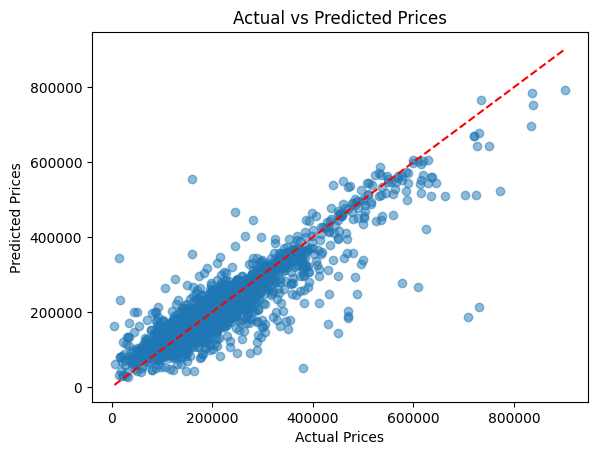

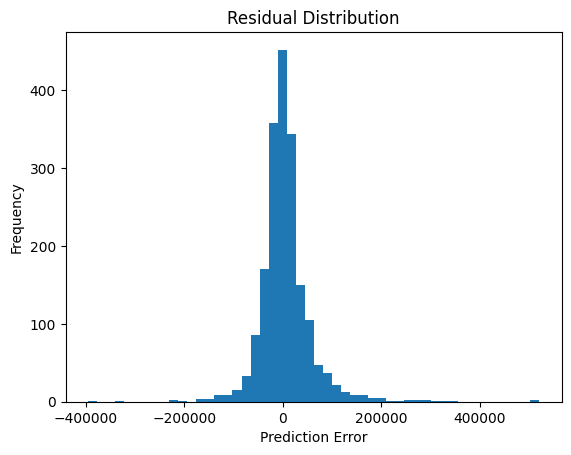

In [78]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()